## Evaluation of Easy-Prime PE2 prediction on diverse edits + Kim et al. 2021
The first part of this Jupyter notebook was adapted from Yichao et al. 2021 (https://github.com/YichaoOU/easy_prime) to evaluate performance of Easy-Prime PE2 model on diverse edits.

Easy-Prime PE2 model was trained on mainly GtoC at Position 5 edits (from Kim et al. 2021, https://www.nature.com/articles/s41587-020-0677-y)
and majority of test-dataset in Yichao et al. was also GtoC Pos5.

To get the performance of Easy-Prime on diverse edits, 1bp replacements at position 5 were removed from the test-dataset (4131 of 4716 edits are 1bp at pos. 5, 585/4716 are diverse edits).

The second part of the notebook is analyzing the models from Kim et al. 2021 (https://www.nature.com/articles/s41587-020-0677-y)

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import scipy
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy import stats
from collections import Counter

In [3]:
lsize=13
titlesize=14
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3')}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
bar_unintended_kwargs = {'color':'#ff9e9e', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = 1.5

In [6]:
# get all PE2 data
Anzalone_PE2 = pd.read_csv("./Anzalone_2019.feature_matrix.csv",index_col=0)
Anzalone_PE2 = Anzalone_PE2[Anzalone_PE2.nick_to_pegRNA.isnull()]
print (Anzalone_PE2.shape) # should be 199
DeepPE = pd.read_csv("./DeepPE.feature_matrix.csv")
DeepPE.head()


(199, 24)


,0,1,2,3,4,5,6,7,8,9,...,PBS_GC,pbs_length,N_subsitution,N_deletion,N_insertions,Target_pos,Target_end_flank,dPAM,Target,type
0,0.014121,0.078609,0.084057,0.069852,0.030430,0.127499,0.151544,0.160713,0.356425,0.403223,...,0.000000,7,1,0,0,5,5,1,0.035112,HT-Training
1,0.012820,0.108751,0.115446,0.095017,0.039857,0.169858,0.199350,0.208493,0.457740,0.506339,...,0.111111,9,1,0,0,5,5,1,0.041597,HT-Training
2,0.067959,0.057805,0.289287,0.271866,0.046149,0.173783,0.205551,0.225851,0.228371,0.103900,...,0.285714,7,1,0,0,5,5,1,0.571349,HT-Training
3,0.030946,0.036186,0.608230,0.664821,0.712692,0.222262,0.147150,0.210832,0.200757,0.358130,...,0.428571,7,1,0,0,5,5,1,0.691117,HT-Training
4,0.990892,0.034533,0.034230,0.120242,0.146871,0.126390,0.046216,0.019104,0.263842,0.319650,...,0.285714,7,1,0,0,5,5,1,6.761687,HT-Training


In [9]:
library1df_original = pd.read_csv("./pridict.featurematrix.csv")
library1df = library1df_original.copy()
cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score',
       'RTT_GC', 'RTT_length', 'PBS_GC', 'PBS_length', 'N_subsitution',
       'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank', 'dPAM']
library1df = library1df[cols]

In [10]:
endogenousdf_original = pd.read_csv("./endogenous.featurematrix.csv")
endogenousdf = endogenousdf_original.copy()
cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score',
       'RTT_GC', 'RTT_length', 'PBS_GC', 'PBS_length', 'N_subsitution',
       'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank', 'dPAM']
endogenousdf = endogenousdf[cols]

In [11]:
f1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score', 'RTT_GC', 'RTT_length', 'PBS_GC', 'PBS_length', 'N_subsitution', 'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank','dPAM']
f2 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score', 'RTT_GC', 'rtt_length', 'PBS_GC', 'pbs_length', 'N_subsitution', 'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank', 'dPAM']
Anzalone_PE2['type'] = 'Train'
d1 = Anzalone_PE2[f1+['type','Target']]
d2 = DeepPE[f2+['type','Target']]
d2.columns = f1+['type','Target']
df = pd.concat([d1,d2])

In [12]:
# build ML model

In [13]:
# CV applied to train set, for tuning parameters, test set is tested independently
def xgb_reg(par=False):
	est = XGBRegressor()
	if par:
		est = XGBRegressor(seed=0,n_jobs=1,**par)
	myDict = {}
	myDict['max_depth']=[2,5,9]
	myDict['learning_rate'] = [0.01,0.1]
	myDict['min_child_weight']=[1,5,10]
	myDict['colsample_bylevel']=[0.6,1]
	myDict['colsample_bytree']=[0.6,1]
	myDict['subsample']=[0.6,1]
	myDict['reg_alpha']=[0,0.1,1]
	myDict['reg_lambda']=[0,1,2]
	return est, myDict

def model_training(X_train,y_train,X_test,y_test,par):
    model,_ = xgb_reg(par)
    model.fit(X_train,y_train)
    myPred = model.predict(X_test)
    my_pred = myPred.tolist()
    my_true = y_test.tolist()
    r,p = scipy.stats.pearsonr(my_true,my_pred)
    sr,sp = scipy.stats.spearmanr(my_true,my_pred)
    r2 = r2_score(my_true,my_pred)
    mae = mean_absolute_error(my_true,my_pred)   
    mse = mean_squared_error(my_true,my_pred)       
    return [r,sr,r2,mae,mse]

def CV_tune_parameter(X,y,nfold):
    """CV code
    
    X is pandas dataframe
    y is pandas Series
    X,y have the same index
    """
    kf = KFold(n_splits=nfold,shuffle=True,random_state=0)
    index_list = X.index.tolist()
    my_pred=[]
    my_true=[]
    best_parameter_list = []
    _,parameter_dict = xgb_reg()
    p_list = list(ParameterGrid(parameter_dict))
    print ("Parameter Space: ",len(p_list))
    for j,i in kf.split(index_list):
        train_group = [index_list[x] for x in i]
        test_group = [index_list[x] for x in j]
        X_train = X.loc[train_group]
        X_test = X.loc[test_group]
        y_train = y.loc[train_group]
        y_test = y.loc[test_group]        
        print (X_train.shape,X_test.shape)
        result_list = Parallel(n_jobs=20,verbose=0,backend='multiprocessing')(delayed(model_training)(X_train,y_train,X_test,y_test,p) for p in p_list)
        result_df = pd.DataFrame(result_list)
        result_df['parameters'] = p_list
#         result_df = result_df.loc[result_df[2].idxmax()]  
        result_df = result_df.loc[result_df[4].idxmin()]  
        best_line = result_df.values.tolist()
        print (result_df)
        best_parameter_list.append(best_line[-1])
    return best_parameter_list
X_train = df[df.type.str.contains("Train",case=False)][f1]
X_test = df[df.type.str.contains("Test",case=False)][f1]
Target = "Target"
y_train = df[df.type.str.contains("Train",case=False)][Target]
y_test = df[df.type.str.contains("Test",case=False)][Target]



In [14]:
len(X_test)

4716

In [15]:
len(y_train)

42097

In [16]:
full_X_test_length = len(X_test)

### Filter test dataset and remove 1bp substitutions at position 5 to get test dataset with diverse edits

In [17]:
X_test = X_test[~((X_test['N_subsitution'] == 1)&(X_test['Target_pos']==5))]
len(X_test)
indlist = X_test.index
y_test = y_test.filter(items = indlist, axis=0)

In [18]:
filtered_X_test_length = len(X_test)

In [19]:
non_pos5_1bp_editnr = full_X_test_length - filtered_X_test_length

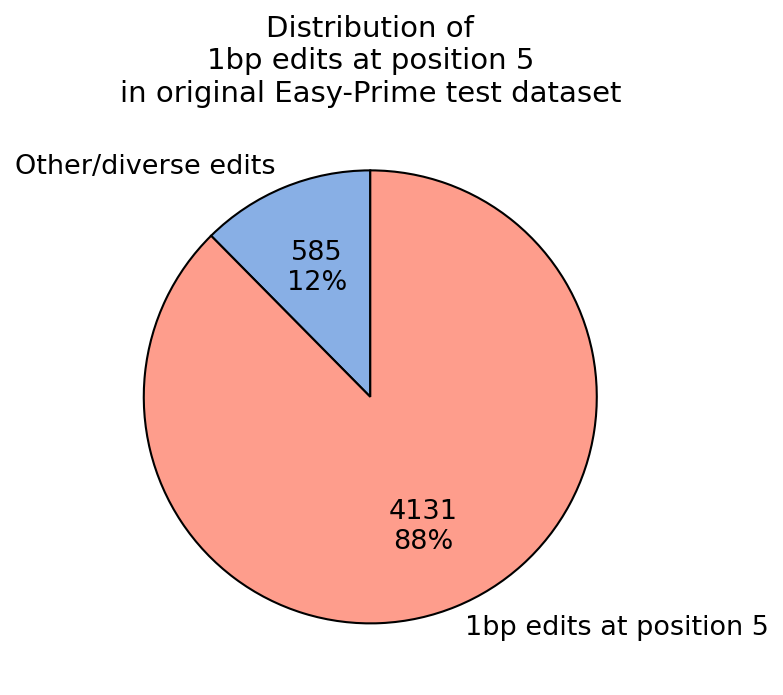

In [73]:
fig16, ax16 = plt.subplots(figsize = (5, 5),dpi=150)
ax16.set_title('Distribution of\n1bp edits at position 5\nin original Easy-Prime test dataset', fontsize=14)
labels = ['Other/diverse edits','1bp edits at position 5']
counts = [filtered_X_test_length,non_pos5_1bp_editnr]
colors = ['#88AFE5','#FE9D8C'] #'#17C62B'

def make_autopct(values,labels):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}\n{p:.0f}%'.format(p=pct,v=val)
    return my_autopct


ax16.pie(counts, colors = colors, labels=labels, autopct= make_autopct(counts,labels), startangle=90,pctdistance=0.62,wedgeprops = {'linewidth': 1,'edgecolor' : "black"}, textprops={'fontsize': 13})
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_testdataset_distribution.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [21]:
#best_parameter_list = CV_tune_parameter(X_train,y_train,5)
best_parameters = {'base_score':0.5, 'booster':None, 'colsample_bylevel':1,
             'colsample_bynode':1, 'colsample_bytree':0.6, 'gamma':0, 'gpu_id':-1,
             'importance_type':'gain', 'interaction_constraints':None,
             'learning_rate':0.1, 'max_delta_step':0, 'max_depth':9,
             'min_child_weight':1, 'missing':None, 'monotone_constraints':None,
             'n_estimators':100, 'num_parallel_tree':1,
             'objective':'reg:squarederror', 'random_state':100, 'reg_alpha':1,
             'reg_lambda':2, 'scale_pos_weight':1, 'subsample':1,
             'tree_method':None, 'validate_parameters':False, 'verbosity':None}

In [23]:
#model,_ = xgb_reg(best_parameters)
import pickle
model = pickle.load(open('PE2_model_final.py', "rb"))
model.fit(X_train,y_train)
myPred = model.predict(X_test)

C:\Users\nimath\Anaconda3\envs\py38\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [24]:
library1pred = model.predict(library1df)

In [25]:
endogenouspred = model.predict(endogenousdf)

In [26]:
library1df_original['easyprimeprediction'] = library1pred
library1df_original = library1df_original[['sample_name','Target','easyprimeprediction']]

endogenousdf_original['easyprimeprediction'] = endogenouspred
endogenousdf_original = endogenousdf_original[['sample_name','Target','easyprimeprediction']]


92423
Pearson correlation: 0.30801844413175017
Spearman correlation: 0.2909457818061154


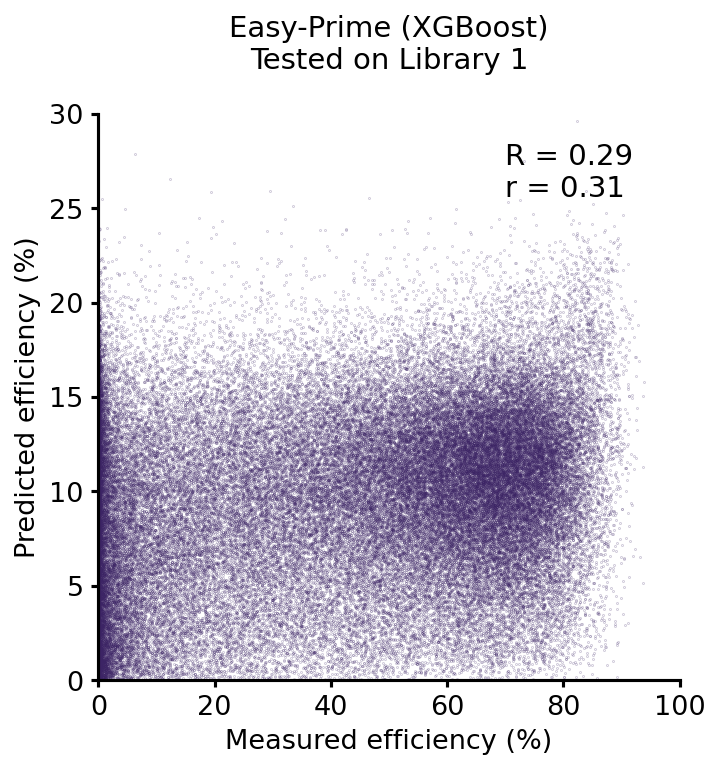

In [33]:
my_pred = [0 if i < 0 else i for i in library1df_original['easyprimeprediction']]
my_true = library1df_original['Target']

print(len(my_true))
r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=0.01)
ax.set_title('Easy-Prime (XGBoost)\nTested on Library 1\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(0,30)
ax.set_xlim(0,100)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_test_on_library1_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


#plt.scatter(my_true,my_pred, c="#3C2465", s=0.001)

## Calculate performance of Easy-Prime on Library 2 datasets

In [28]:
library2easyprimedf = pd.read_csv('20221002_library2_with_easyprimeprediction_dataframe.csv')


In [29]:
library2easyprimedf.columns

Index(['Unnamed: 0', 'finalname', 'uniqueindex_subscreen',
       'uniqueindex_largescreen', 'Name', 'RToverhanglength', 'RTlength',
       'ReferenceAllele', 'AlternateAllele', 'Correction_Type',
       'Correction_Length', 'Editing_Position_Deep',
       'protospacerlocation_only_initial', 'PBSlocation',
       'RT_initial_location', 'RT_mutated_location', 'wide_initial_target',
       'wide_mutated_target', 'HEKOpti-Scaffold_PE2_averageedited',
       'HEKOpti-Scaffold_PE2_averageunedited',
       'HEKOpti-Scaffold_PE2_averageindel', 'K562_PE2_averageedited',
       'K562_PE2_averageunedited', 'K562_PE2_averageindel',
       'K562_PE2-dnMLH1_averageedited', 'K562_PE2-dnMLH1_averageunedited',
       'K562_PE2-dnMLH1_averageindel', 'Liver-GFPplus_PE2Adeno_averageedited',
       'Liver-GFPplus_PE2Adeno_averageunedited',
       'Liver-GFPplus_PE2Adeno_averageindel', 'deepcas9', 'MFE_protospacer',
       'MFE_protospacer_scaffold', 'MFE_extension', 'MFE_extension_scaffold',
       'MFE_p

In [30]:
library2easyprimedf_nontevopreq = library2easyprimedf[library2easyprimedf['tevopreq'] == False].copy()
library2easyprimedf_tevopreq = library2easyprimedf[library2easyprimedf['tevopreq'] == True].copy()

915
Pearson correlation: 0.37347408995065745
Spearman correlation: 0.3734850843665419


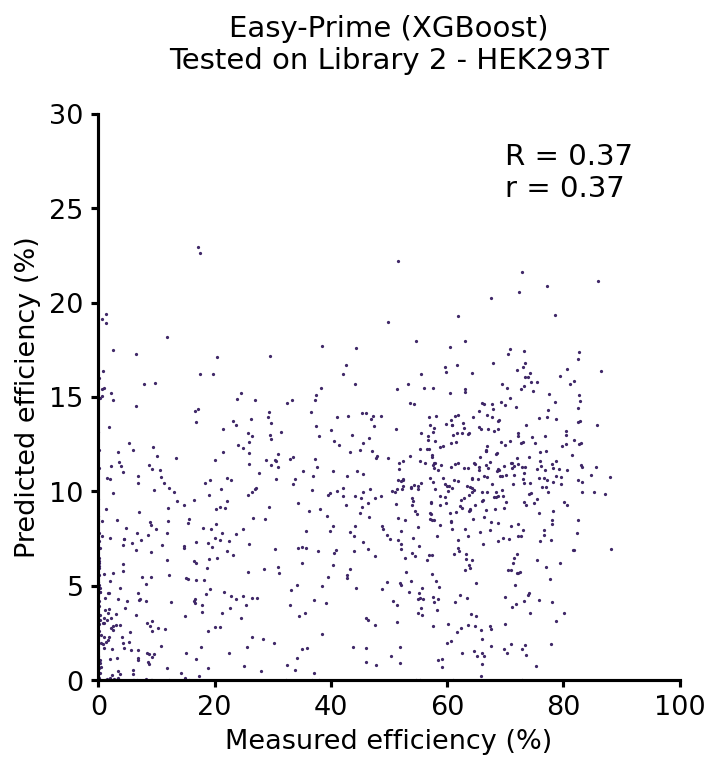

In [32]:
hekpe2nontevopreqdf = library2easyprimedf_nontevopreq.copy()
hekpe2nontevopreqdf = library2easyprimedf_nontevopreq.dropna(subset = ['HEKOpti-Scaffold_PE2_averageedited'])

my_pred = [0 if i < 0 else i for i in hekpe2nontevopreqdf['easyprimeprediction']] 
my_true = hekpe2nontevopreqdf['HEKOpti-Scaffold_PE2_averageedited']

print(len(my_true))
r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=0.3)
ax.set_title('Easy-Prime (XGBoost)\nTested on Library 2 - HEK293T\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(0,30)
ax.set_xlim(0,100)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_test_on_library2_hek293tpe2_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

876
Pearson correlation: 0.2137221110523227
Spearman correlation: 0.33738870991985837


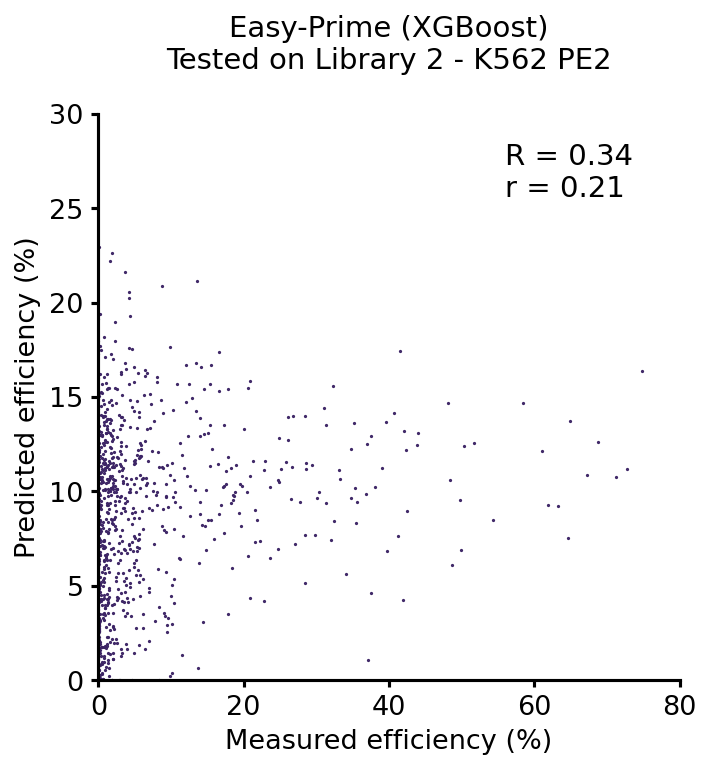

In [34]:
k562pe2nontevopreqdf = library2easyprimedf_nontevopreq.copy()
k562pe2nontevopreqdf = library2easyprimedf_nontevopreq.dropna(subset = ['K562_PE2_averageedited'])

my_pred = [0 if i < 0 else i for i in k562pe2nontevopreqdf['easyprimeprediction']] 
my_true = k562pe2nontevopreqdf['K562_PE2_averageedited']

print(len(my_true))
r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=0.3)
ax.set_title('Easy-Prime (XGBoost)\nTested on Library 2 - K562 PE2\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(0,30)
ax.set_xlim(0,80)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_test_on_library2_k562tpe2_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

869
Pearson correlation: 0.10436068685085978
Spearman correlation: 0.1888148805071512


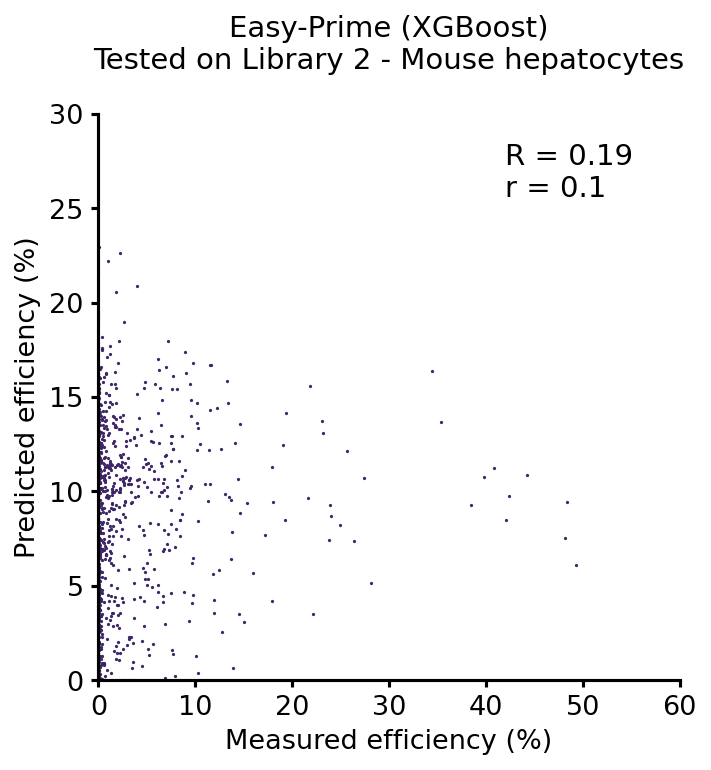

In [35]:
mousenontevopreqdf = library2easyprimedf_nontevopreq.copy()
mousenontevopreqdf = library2easyprimedf_nontevopreq.dropna(subset = ['Liver-GFPplus_PE2Adeno_averageedited'])

my_pred = [0 if i < 0 else i for i in mousenontevopreqdf['easyprimeprediction']] 
my_true = mousenontevopreqdf['Liver-GFPplus_PE2Adeno_averageedited']

print(len(my_true))
r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=0.3)
ax.set_title('Easy-Prime (XGBoost)\nTested on Library 2 - Mouse hepatocytes\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(0,30)
ax.set_xlim(0,60)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_test_on_library2_mouse_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## Calculate differences in predicitng best/worst pegRNAs for EasyPrime and PRIDICT

In [36]:
library1df_full = pd.read_csv('20220719_FINAL_Editingtable_focused_NM_withindex.csv')
library1df_full['easyprimeprediction'] = library1df_original['easyprimeprediction']
uniquenames = library1df_full.Name.unique()

In [37]:
predpath = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44\\"

preddf = pd.read_csv(predpath+"pred_df_20_run0.csv")
for x in range(1,5):
    preddftemp = pd.read_csv(predpath+"pred_df_20_run"+str(x)+".csv")
    preddf = preddf.append(preddftemp)
print(len(preddf))
preddf['uniqueindex'] = preddf.seq_id.apply(lambda x: int(x[4:]))
preddf = preddf.set_index('uniqueindex')
library1df_full['pridict_score_testset'] = preddf['pred_averageedited']

92423


In [38]:
highestlowestdic = {}

for asc in [False,True]:
    
    easyprimerank_of_highestediting_list = []
    editingrank_at_highesteasyprediction_list = []

    pridictrank_of_highestediting_list = []
    editingrank_at_highestpridictprediction_list = []
    totalloci = 0
    numberofpegsperlocuslist = []
    highpridictperlocuslist = []
    for target in uniquenames:

        targetdf = library1df_full[library1df_full['Name'] == target].copy()
        targetdf['easyprimerank'] = targetdf.easyprimeprediction.rank(ascending=asc)
        targetdf['pridictrank'] = targetdf.pridict_score_testset.rank(ascending=asc)
        targetdf['editingrank'] = targetdf.averageedited.rank(ascending=asc)
        highpridictperlocuslist.append((targetdf.pridict_score_testset > 0.7).any())  # add True if any of the predictions are above PRIDICT score of 70. Put False otherwise.

        if not 1 in targetdf.editingrank.unique():  # skip analysis if no rank 1 can be found (if multiple guides are nr 1)
            continue
        if len(targetdf.editingrank) <3:  # skip analysis if less than 4 pegRNAs available for comparison
            continue
        highesteditingindex = targetdf['editingrank'].idxmin()
        easyprimerank_at_highest_editing = targetdf.at[highesteditingindex, 'easyprimerank']
        easyprimerank_of_highestediting_list.append(easyprimerank_at_highest_editing)

        pridictrank_at_highest_editing = targetdf.at[highesteditingindex, 'pridictrank']
        pridictrank_of_highestediting_list.append(pridictrank_at_highest_editing)

        highesteasypredicitonindex = targetdf['easyprimerank'].idxmin()
        editingrank_at_highest_easyprediction = targetdf.at[highesteasypredicitonindex, 'editingrank']
        editingrank_at_highesteasyprediction_list.append(editingrank_at_highest_easyprediction)

        highestpridictpredicitonindex = targetdf['pridictrank'].idxmin()
        editingrank_at_highest_pridictprediction = targetdf.at[highestpridictpredicitonindex, 'editingrank']
        editingrank_at_highestpridictprediction_list.append(editingrank_at_highest_pridictprediction)
        totalloci+=1
        numberofpegsperlocuslist.append(len(targetdf))
        
    if asc == False:
        highestlowestdic['highest'] = {'easyprimerank_of_editing_list':easyprimerank_of_highestediting_list,'pridictrank_of_editing_list':pridictrank_of_highestediting_list,'editingrank_at_easyprediction_list':editingrank_at_highesteasyprediction_list,'editingrank_at_pridictprediction_list':editingrank_at_highestpridictprediction_list}
    if asc == True:
        highestlowestdic['lowest'] = {'easyprimerank_of_editing_list':easyprimerank_of_highestediting_list,'pridictrank_of_editing_list':pridictrank_of_highestediting_list,'editingrank_at_easyprediction_list':editingrank_at_highesteasyprediction_list,'editingrank_at_pridictprediction_list':editingrank_at_highestpridictprediction_list}
    
print('Average nr. of pegRNAs per pathogenic locus:',sum(numberofpegsperlocuslist)/len(numberofpegsperlocuslist))

Average nr. of pegRNAs per pathogenic locus: 7.0534088112232345


In [39]:
Counter(numberofpegsperlocuslist)

Counter({7: 1011,
         12: 1728,
         6: 422,
         8: 2321,
         5: 270,
         4: 3712,
         3: 1017,
         11: 1000,
         10: 440,
         9: 268})

In [40]:
len(numberofpegsperlocuslist)

12189

In [41]:
x = highestlowestdic['highest']['editingrank_at_easyprediction_list']
easyhigh = [(Counter(x)[1.0]+Counter(x)[1.5])/totalloci, (Counter(x)[2.0]+Counter(x)[2.5])/totalloci, (Counter(x)[3.0]+Counter(x)[3.5])/totalloci, (Counter(x)[4.0]+Counter(x)[4.5])/totalloci]
print(easyhigh)

[0.19542210189515136, 0.17761916482074, 0.17843957666748708, 0.1617031749938469]


In [42]:
x = highestlowestdic['highest']['editingrank_at_pridictprediction_list']
pridicthigh = [(Counter(x)[1.0]+Counter(x)[1.5])/totalloci, (Counter(x)[2.0]+Counter(x)[2.5])/totalloci, (Counter(x)[3.0]+Counter(x)[3.5])/totalloci, (Counter(x)[4.0]+Counter(x)[4.5])/totalloci]
print(pridicthigh)

[0.5086553449831815, 0.2602346377881697, 0.13175814258757895, 0.06883255394207892]


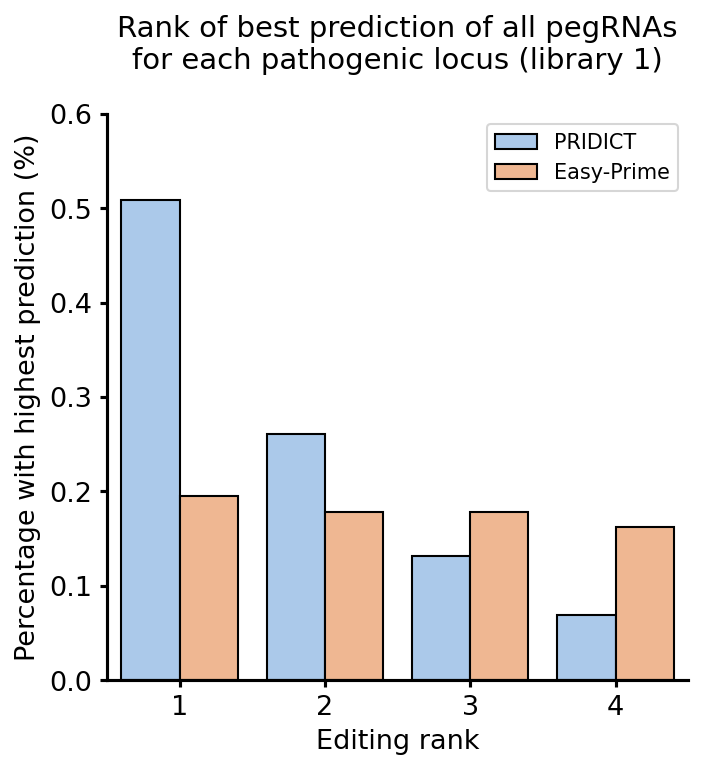

In [43]:
easyhigh_grouped_df = pd.DataFrame()
pridicthigh_grouped_df = pd.DataFrame()

easyhigh_grouped_df['percentage'] = easyhigh
easyhigh_grouped_df['rank'] = range(1,5)
easyhigh_grouped_df['prediction'] = 'Easy-Prime'

pridicthigh_grouped_df['percentage'] = pridicthigh
pridicthigh_grouped_df['rank'] = range(1,5)
pridicthigh_grouped_df['prediction'] = 'PRIDICT'

high_grouped_df = pridicthigh_grouped_df.append(easyhigh_grouped_df)

sn.reset_orig()
fig2, ax3 = plt.subplots(1,1,figsize = (5,5),dpi=150)
ax3.set_title('Rank of best prediction of all pegRNAs\nfor each pathogenic locus (library 1)\n', fontsize=titlesize)
ax = sn.barplot(x='rank',y='percentage',hue='prediction',data=high_grouped_df, ax = ax3, palette='pastel', edgecolor = 'black')
sn.despine()
plt.gca().legend().set_title('')
ax.set_ylabel('Percentage with highest prediction (%)', fontsize = lsize)
ax.set_xlabel('Editing rank', fontsize = lsize)
ax.set(ylim=(0, 0.6))
ax.tick_params(width = 1.5,labelsize=lsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_xticklabels(range(1,5))
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'ranking_pegRNAs_lib1_easyprime_pridict.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [44]:
pridicthigh_grouped_df

,percentage,rank,prediction
0,0.508655,1,PRIDICT
1,0.260235,2,PRIDICT
2,0.131758,3,PRIDICT
3,0.068833,4,PRIDICT


In [45]:
x = highestlowestdic['lowest']['editingrank_at_easyprediction_list']
easylow = [(Counter(x)[1.0]+Counter(x)[1.5])/totalloci, (Counter(x)[2.0]+Counter(x)[2.5])/totalloci, (Counter(x)[3.0]+Counter(x)[3.5])/totalloci, (Counter(x)[4.0]+Counter(x)[4.5])/totalloci]

x = highestlowestdic['lowest']['editingrank_at_pridictprediction_list']
pridictlow = [(Counter(x)[1.0]+Counter(x)[1.5])/totalloci, (Counter(x)[2.0]+Counter(x)[2.5])/totalloci, (Counter(x)[3.0]+Counter(x)[3.5])/totalloci, (Counter(x)[4.0]+Counter(x)[4.5])/totalloci]


[Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')]

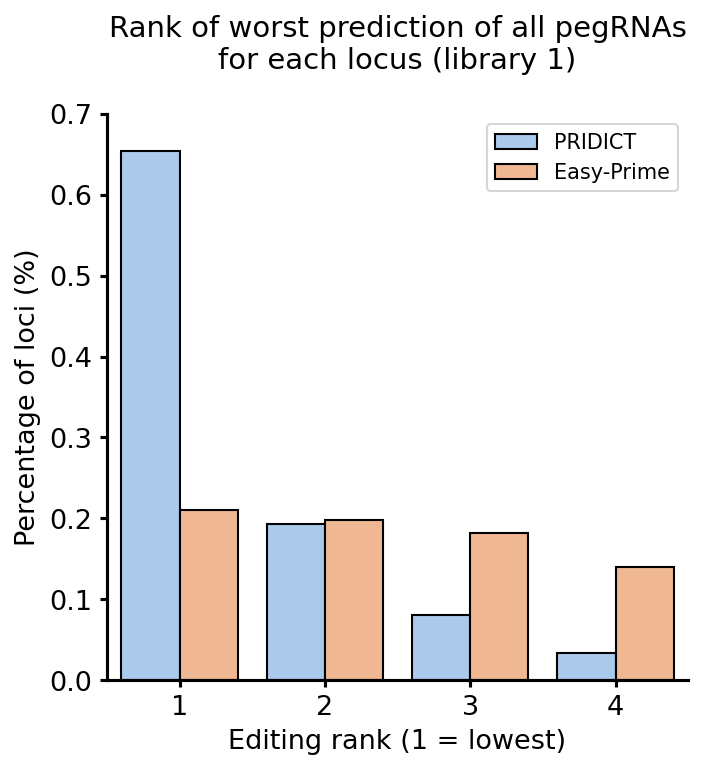

In [46]:
easylow_grouped_df = pd.DataFrame()
pridictlow_grouped_df = pd.DataFrame()

easylow_grouped_df['percentage'] = easylow
easylow_grouped_df['rank'] = range(1,5)
easylow_grouped_df['prediction'] = 'Easy-Prime'

pridictlow_grouped_df['percentage'] = pridictlow
pridictlow_grouped_df['rank'] = range(1,5)
pridictlow_grouped_df['prediction'] = 'PRIDICT'

low_grouped_df = pridictlow_grouped_df.append(easylow_grouped_df)

sn.reset_orig()
fig2, ax3 = plt.subplots(1,1,figsize = (5,5),dpi=150)
ax3.set_title('Rank of worst prediction of all pegRNAs\nfor each locus (library 1)\n', fontsize=titlesize)
ax = sn.barplot(x='rank',y='percentage',hue='prediction',data=low_grouped_df, ax = ax3,palette='pastel', edgecolor = 'black')
sn.despine()
plt.gca().legend().set_title('')
ax.set_ylabel('Percentage of loci (%)', fontsize = lsize)
ax.set_xlabel('Editing rank (1 = lowest)', fontsize = lsize)
ax.set(ylim=(0, 0.7))
ax.tick_params(width = 1.5,labelsize=lsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_xticklabels(range(1,5))

In [47]:
predpath = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_endogseqs_withindel\\exp_2022-07-19_18-10-44\\"
endogenouspridictdf = pd.read_csv(predpath+'pred_df_wsize20.csv')
endogenouspridictdf['ind'] = endogenouspridictdf.seq_id.apply(lambda x: int(x[4:]))
endogenouspridictdf = endogenouspridictdf.set_index('ind')
endogenousdf_original['pridict'] = endogenouspridictdf['pred_averageedited']
endogenousdf_original = endogenousdf_original.set_index('sample_name')

In [48]:
locilist = ['01','03','05','06','09','17','20','26','28','31','33','EMX12b10','FANCF2b10','HEK32b20','RNF22b14']
for locus in locilist:
    for peg in ['libbestpeg','libendopeg','libworstpeg']:
        endogenousdf_original.at[locus+peg,'locus'] = locus

In [49]:
endogenoushighestlowestdic = {}

for asc in [False,True]:
    
    easyprimerank_of_highestediting_list = []
    editingrank_at_highesteasyprediction_list = []

    pridictrank_of_highestediting_list = []
    editingrank_at_highestpridictprediction_list = []
    endototalloci = 0

    for locus in locilist:

        targetdf = endogenousdf_original[endogenousdf_original['locus'] == locus].copy()
        targetdf['easyprimerank'] = targetdf.easyprimeprediction.rank(ascending=asc)
        targetdf['pridictrank'] = targetdf.pridict.rank(ascending=asc)
        targetdf['editingrank'] = targetdf.Target.rank(ascending=asc)

        if not 1 in targetdf.editingrank.unique():  # skip analysis if no rank 1 can be found (if multiple guides are nr 1)
            continue

        highesteditingindex = targetdf['editingrank'].idxmin()
        easyprimerank_at_highest_editing = targetdf.at[highesteditingindex, 'easyprimerank']
        easyprimerank_of_highestediting_list.append(easyprimerank_at_highest_editing)

        pridictrank_at_highest_editing = targetdf.at[highesteditingindex, 'pridictrank']
        pridictrank_of_highestediting_list.append(pridictrank_at_highest_editing)

        highesteasypredicitonindex = targetdf['easyprimerank'].idxmin()
        editingrank_at_highest_easyprediction = targetdf.at[highesteasypredicitonindex, 'editingrank']
        editingrank_at_highesteasyprediction_list.append(editingrank_at_highest_easyprediction)


        highestpridictpredicitonindex = targetdf['pridictrank'].idxmin()
        editingrank_at_highest_pridictprediction = targetdf.at[highestpridictpredicitonindex, 'editingrank']
        editingrank_at_highestpridictprediction_list.append(editingrank_at_highest_pridictprediction)
        endototalloci+=1
    
    if asc == False:
        endogenoushighestlowestdic['highest'] = {'easyprimerank_of_editing_list':easyprimerank_of_highestediting_list,'pridictrank_of_editing_list':pridictrank_of_highestediting_list,'editingrank_at_easyprediction_list':editingrank_at_highesteasyprediction_list,'editingrank_at_pridictprediction_list':editingrank_at_highestpridictprediction_list}
    if asc == True:
        endogenoushighestlowestdic['lowest'] = {'easyprimerank_of_editing_list':easyprimerank_of_highestediting_list,'pridictrank_of_editing_list':pridictrank_of_highestediting_list,'editingrank_at_easyprediction_list':editingrank_at_highesteasyprediction_list,'editingrank_at_pridictprediction_list':editingrank_at_highestpridictprediction_list}

In [50]:
endototalloci

15

In [51]:
x = endogenoushighestlowestdic['highest']['editingrank_at_easyprediction_list']
endoeasyhigh = [(Counter(x)[1.0]+Counter(x)[1.5])/endototalloci, (Counter(x)[2.0]+Counter(x)[2.5])/endototalloci, (Counter(x)[3.0]+Counter(x)[3.5])/endototalloci]
print(endoeasyhigh)

[0.4, 0.2, 0.4]


In [52]:
x = endogenoushighestlowestdic['highest']['editingrank_at_pridictprediction_list']
endopridicthigh = [(Counter(x)[1.0]+Counter(x)[1.5])/endototalloci, (Counter(x)[2.0]+Counter(x)[2.5])/endototalloci, (Counter(x)[3.0]+Counter(x)[3.5])/endototalloci]
print(endopridicthigh)

[0.6, 0.4, 0.0]


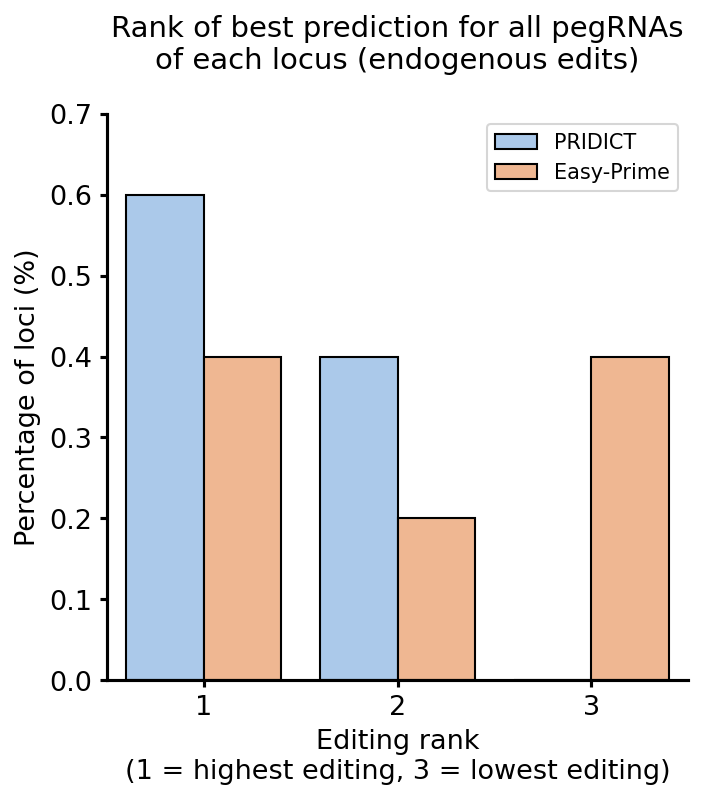

In [53]:
endoeasyhigh_grouped_df = pd.DataFrame()
endopridicthigh_grouped_df = pd.DataFrame()

endoeasyhigh_grouped_df['percentage'] = endoeasyhigh
endoeasyhigh_grouped_df['rank'] = range(1,4)
endoeasyhigh_grouped_df['prediction'] = 'Easy-Prime'

endopridicthigh_grouped_df['percentage'] = endopridicthigh
endopridicthigh_grouped_df['rank'] = range(1,4)
endopridicthigh_grouped_df['prediction'] = 'PRIDICT'

endohigh_grouped_df = endopridicthigh_grouped_df.append(endoeasyhigh_grouped_df)

sn.reset_orig()
fig2, ax3 = plt.subplots(1,1,figsize = (5,5),dpi=150)
ax3.set_title('Rank of best prediction for all pegRNAs\nof each locus (endogenous edits)\n', fontsize=titlesize)
ax = sn.barplot(x='rank',y='percentage',hue='prediction',data=endohigh_grouped_df, ax = ax3,palette='pastel', edgecolor = 'black')
sn.despine()
plt.gca().legend().set_title('')
ax.set_ylabel('Percentage of loci (%)', fontsize = lsize)
ax.set_xlabel('Editing rank\n(1 = highest editing, 3 = lowest editing)', fontsize = lsize)
ax.set(ylim=(0, 0.7))
ax.tick_params(width = 1.5,labelsize=lsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_xticklabels(range(1,4))
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'ranking_pegRNAs_endogenous_easyprime_pridict.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [54]:
endopath = "C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\02_Arrayed\\Sequencing\\NGS\\"
K562_endogenousdf = pd.read_csv(endopath+"20220719_Editing_Endogenous_K562_deep_new.csv")
K562_endogenousdf = K562_endogenousdf.set_index("Unnamed: 0")

In [55]:
endogenousdf_original['K562_truescore'] = K562_endogenousdf['average_between_bio_replicates']

Pearson correlation: 0.1897148886858528
Spearman correlation: 0.2571805006587615


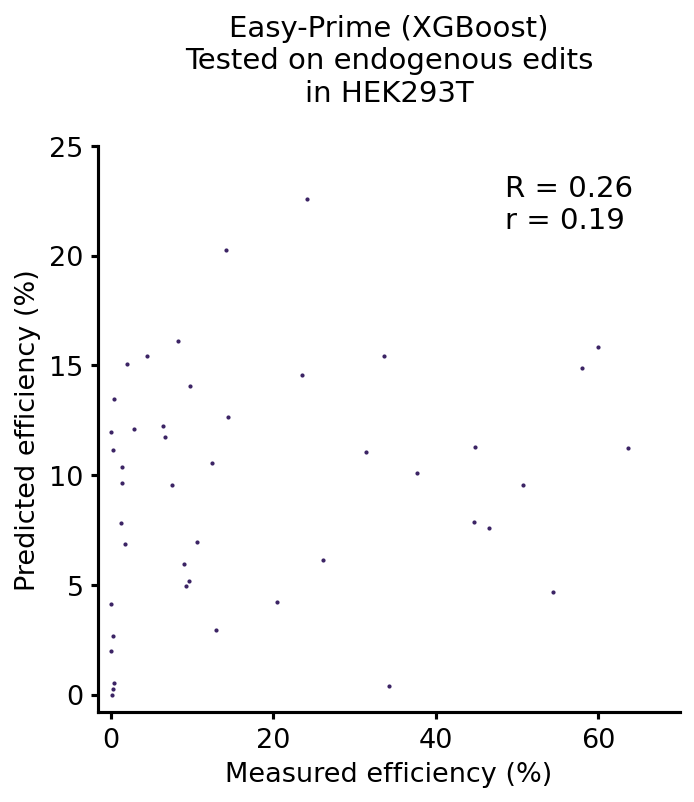

In [57]:
my_pred = [0 if i < 0 else i for i in endogenousdf_original['easyprimeprediction']]
my_true = endogenousdf_original['Target']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('Easy-Prime (XGBoost)\nTested on endogenous edits\nin HEK293T\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(-0.8,25)
ax.set_xlim(-1.5,70)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_test_on_HEKendogenous_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')



Pearson correlation: 0.20817875445904735
Spearman correlation: 0.23069828722002633


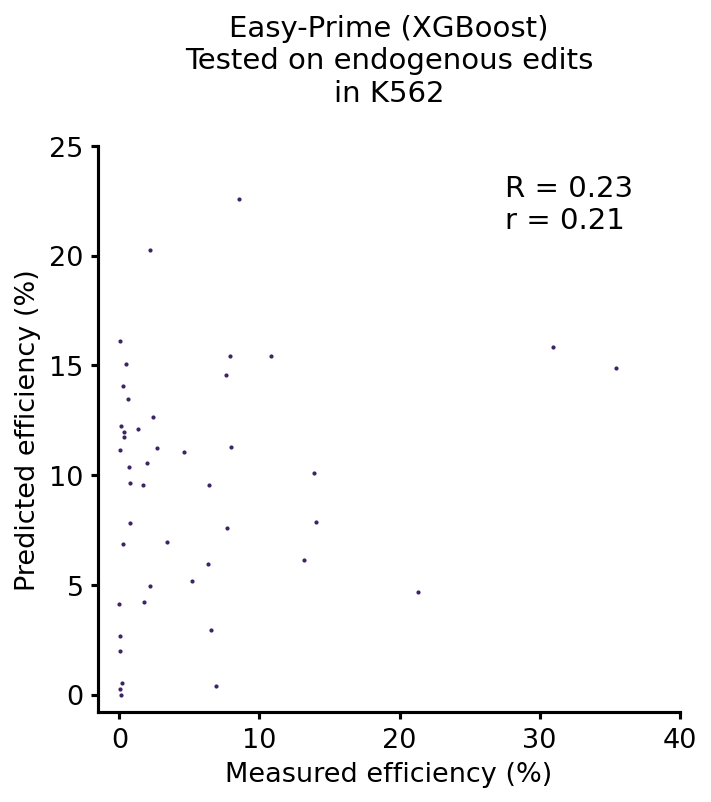

In [58]:
my_pred = [0 if i < 0 else i for i in endogenousdf_original['easyprimeprediction']]
my_true = endogenousdf_original['K562_truescore']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('Easy-Prime (XGBoost)\nTested on endogenous edits\nin K562\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(-0.8,25)
ax.set_xlim(-1.5,40)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_test_on_K562endogenous_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


In [59]:
endogenousdf_original['name'] = endogenousdf_original.index
endogenousdf_original['endo'] = endogenousdf_original['name'].apply(lambda x: 'endo' if 'endo' in x else None)
endogenousdf_endoonly = endogenousdf_original[endogenousdf_original['endo'] == 'endo'].copy()

Pearson correlation: 0.07938059511789476
Spearman correlation: 0.24642857142857136


Text(0.7, 0.95, 'R = 0.25\nr = 0.08')

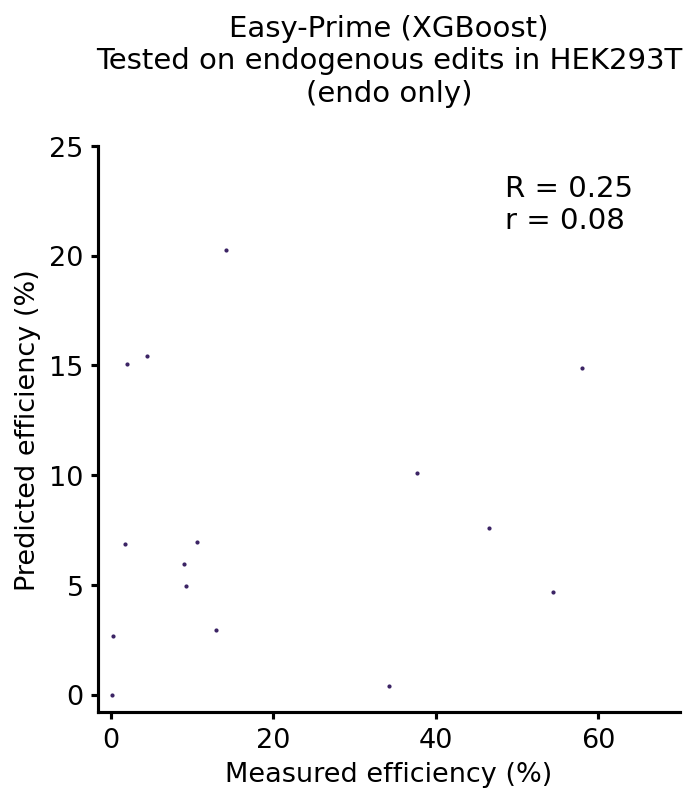

In [60]:
my_pred = [0 if i < 0 else i for i in endogenousdf_endoonly['easyprimeprediction']]
my_true = endogenousdf_endoonly['Target']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('Easy-Prime (XGBoost)\nTested on endogenous edits in HEK293T\n(endo only)\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(-0.8,25)
ax.set_xlim(-1.5,70)
ax.text(0.7,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')


In [61]:
def plot_ML_scatter(my_true,my_pred,output_file,max_value,min_value=-2):
	outer_df = pd.DataFrame()
	outer_df['true'] = my_true
	outer_df['pred'] = my_pred
	sns.set_style("ticks")
	plt.figure(figsize=(6,6))
	r,p = scipy.stats.pearsonr(my_true,my_pred)
	sr,p = scipy.stats.spearmanr(my_true,my_pred)
	x="true"
	y='pred'
	linewidth=3
	sns.regplot(data=outer_df,x=x,y=y,scatter=True,scatter_kws={'alpha':0.3,'s':4,"color":"grey"},
				line_kws={'linewidth':linewidth,'color':'black'},fit_reg=True)
	plt.legend(['R=%.2f\nr=%.2f'%(sr,r)])
	plt.xlim(min_value,max_value)
	plt.ylim(min_value,max_value)
	plt.xlabel("True efficiency")
	plt.ylabel("Predicted efficiency")
	plt.savefig("%s.corr.scatter.pdf"%(output_file),bbox_inches='tight')

In [62]:
my_pred = [0 if i < 0 else i for i in myPred.tolist()]
my_true = y_test.tolist()
index_list = X_test.index.tolist()
outer_df = pd.DataFrame()
outer_df['true'] = my_true
outer_df['pred'] = my_pred
outer_df.index = index_list
r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))

%matplotlib inline

#plot_ML_scatter(my_true,my_pred,"PE2_model",50)

Pearson correlation: 0.5609202351451188
Spearman correlation: 0.5383277871700279


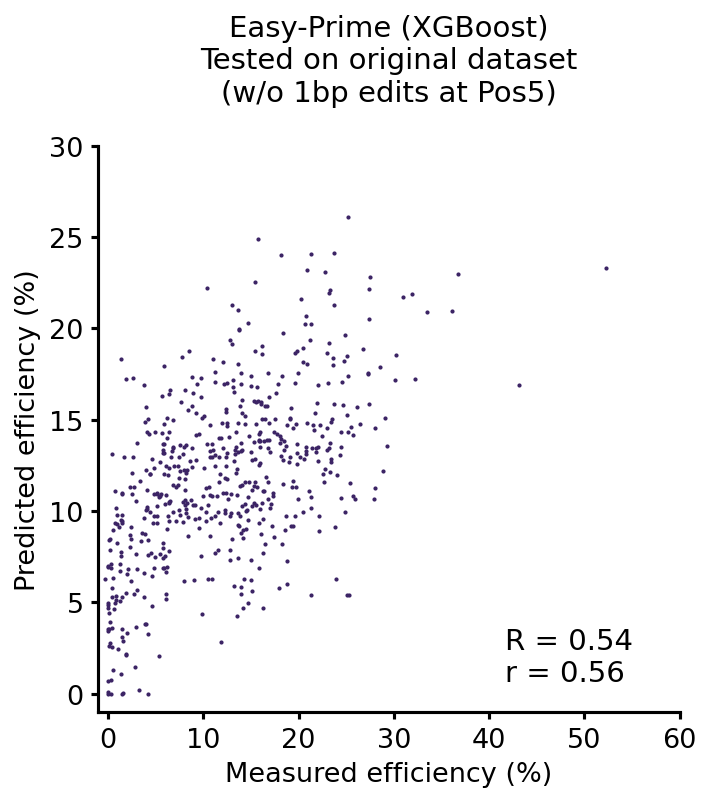

In [63]:
my_pred = np.array(my_pred)
my_true = np.array(my_true)

rnnatt_R = stats.spearmanr(my_pred,my_true)[0]
rnnatt_r = stats.pearsonr(my_pred,my_true)[0]




fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('Easy-Prime (XGBoost)\nTested on original dataset\n(w/o 1bp edits at Pos5)\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(-1,30)
ax.set_xlim(-1,60)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'easyprime_diverse_test_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
#print(len(run4replacementdf))

## Analyze Kim et al. datasets

In [64]:
deeppe_endogenousdf = pd.read_csv("./20220807_DeepPE_Type_Positon_Predictions_of_endogenous_targets.csv")
deeppe_endogenousdf = deeppe_endogenousdf.set_index("gene")
endopath = "C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\02_Arrayed\\Sequencing\\NGS\\"
K562_endogenousdf = pd.read_csv(endopath+"20220719_Editing_Endogenous_K562_deep_new.csv")
K562_endogenousdf = K562_endogenousdf.set_index("Unnamed: 0")

In [65]:
deeppe_endogenousdf['K562_truescore'] = K562_endogenousdf["average_between_bio_replicates"]

In [66]:
deeppe_endogenousdf_filtered = deeppe_endogenousdf.dropna(subset=['prediction'])
deeppe_endogenousdf_filtered = deeppe_endogenousdf_filtered[deeppe_endogenousdf_filtered['predictionmodel'] == 'DeepPE']  # only compare DeepPE which each other since there is only value from Position and 1 value from Type model


In [67]:
len(deeppe_endogenousdf)

45

In [68]:
deeppe_endogenousdf_filteredwithout20 = deeppe_endogenousdf_filtered[~deeppe_endogenousdf_filtered['target_mutation'].str.contains("20")].copy()

my_pred = [0 if i < 0 else i for i in deeppe_endogenousdf_filteredwithout20['prediction']]
my_true = deeppe_endogenousdf_filteredwithout20['Target']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)

print('HEK293T without locus 20',round(sr,2))

my_pred = [0 if i < 0 else i for i in deeppe_endogenousdf_filteredwithout20['prediction']]
my_true = deeppe_endogenousdf_filteredwithout20['K562_truescore']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)

print('K562 without locus 20',round(sr,2))

HEK293T without locus 20 0.39
K562 without locus 20 0.49


Pearson correlation: 0.5781465693868555
Spearman correlation: 0.574083710990649


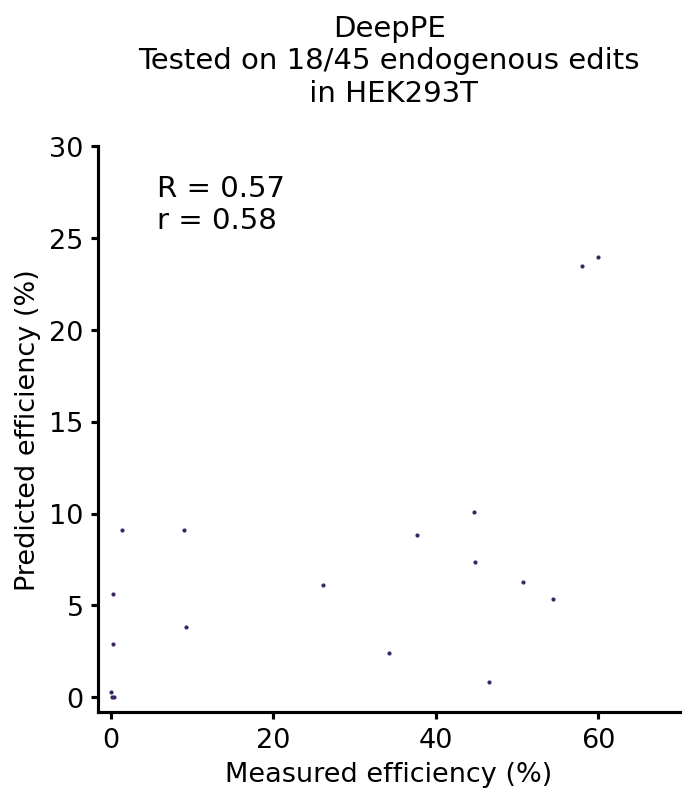

In [70]:
my_pred = [0 if i < 0 else i for i in deeppe_endogenousdf_filtered['prediction']]
my_true = deeppe_endogenousdf_filtered['Target']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('DeepPE\nTested on 18/45 endogenous edits\n in HEK293T\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=0.2)
ax.set_ylim(-0.8,30)
ax.set_xlim(-1.5,70)
ax.text(0.1,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'deeppe_test_on_HEK293Tendogenous_subset_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

Pearson correlation: 0.8443727569679523
Spearman correlation: 0.640165289234177


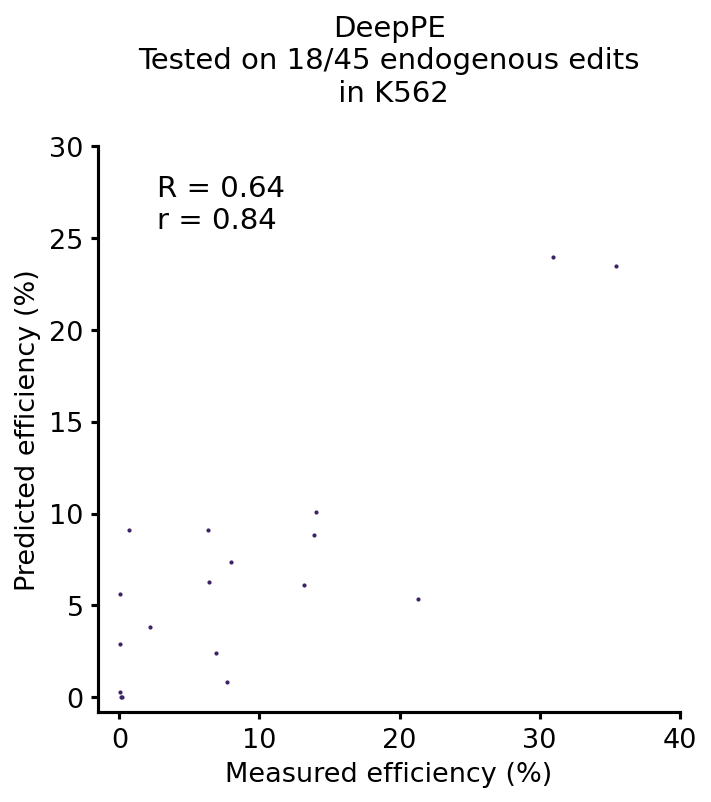

In [71]:
my_pred = [0 if i < 0 else i for i in deeppe_endogenousdf_filtered['prediction']]
my_true = deeppe_endogenousdf_filtered['K562_truescore']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('DeepPE\nTested on 18/45 endogenous edits\n in K562\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
#ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(-0.8,30)
ax.set_xlim(-1.5,40)
ax.text(0.1,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'deeppe_test_on_K562endogenous_subset_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


Pearson correlation: 0.4686517048258816
Spearman correlation: 0.4900663578396291


Text(0.1, 0.95, 'R = 0.49\nr = 0.47')

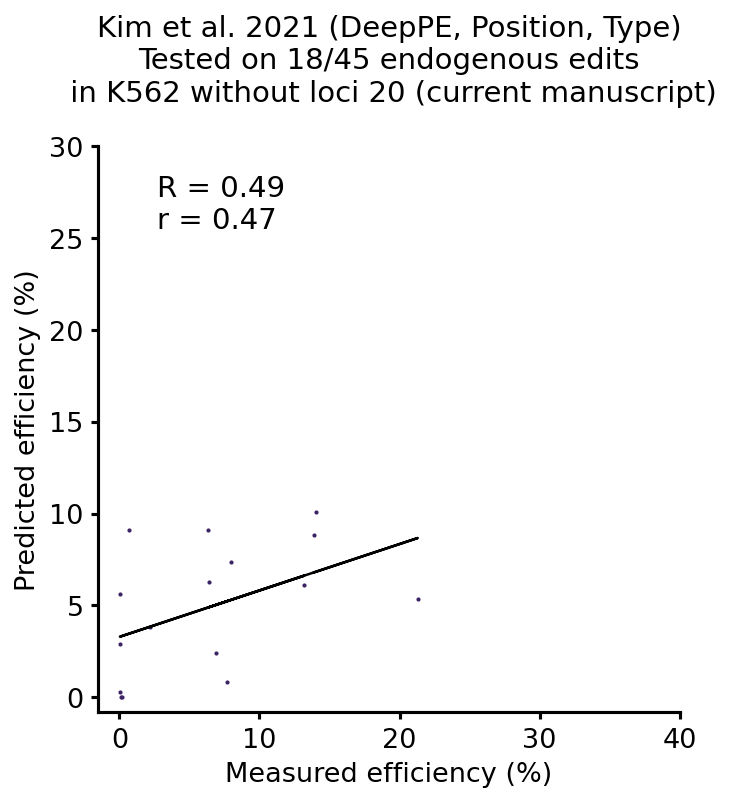

In [72]:
deeppe_endogenousdf_filtered[(deeppe_endogenousdf_filtered['Unnamed: 0'] != 18) & (deeppe_endogenousdf_filtered['Unnamed: 0'] != 19)]

my_pred = [0 if i < 0 else i for i in deeppe_endogenousdf_filtered[(deeppe_endogenousdf_filtered['Unnamed: 0'] != 18) & (deeppe_endogenousdf_filtered['Unnamed: 0'] != 19)]['prediction']]
my_true = deeppe_endogenousdf_filtered[(deeppe_endogenousdf_filtered['Unnamed: 0'] != 18) & (deeppe_endogenousdf_filtered['Unnamed: 0'] != 19)]['K562_truescore']

r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))


fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(my_true,my_pred, c="#3C2465", s=1)
ax.set_title('Kim et al. 2021 (DeepPE, Position, Type)\nTested on 18/45 endogenous edits\n in K562 without loci 20 (current manuscript)\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(my_true,my_pred, 1)
ax.plot(my_true, m*my_true + b, color='black', linewidth=1.2)
ax.set_ylim(-0.8,30)
ax.set_xlim(-1.5,40)
ax.text(0.1,0.95, 'R = '+str(round(sr,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
